In [1]:
#!/usr/bin/env python
# coding: utf-8


import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pickle 

from helpers.synthesis import *
from helpers.visualization import *

plt.style.use("science.mplstyle")

dpi = 800

In [2]:
scatterplot_dir = "/global/ml4hep/spss/rrmastandrea/synth_SM_AD/NF_results_SSS/"


n_seed = 1 # just want one seed to compare scores I think

num_bkg = 340000
num_sig = 20000

In [3]:
# Load in the data


num_signals_to_inject = [0, 300, 500, 750, 1000, 1200, 1500, 2000, 2500, 3000]

synth_ids = ["feta", "cathode", "curtains", "salad"]


summary_dict_bkg, summary_dict_sig = {}, {}


# load in and concatentate data
for nn in num_signals_to_inject:

    all_results_bkg, all_results_sig = load_in_data(nn, num_bkg, "StandardScale", synth_ids, n_seed, scatterplot_dir)    
    concatenated_results_bkg, concatenated_results_sig = concatenate_scatterplot_data(all_results_bkg, all_results_sig, synth_ids, n_seed)

    summary_dict_bkg[nn] = concatenated_results_bkg
    summary_dict_sig[nn] = concatenated_results_sig
    

In [4]:
def get_highest_percentile(scores, num_ids_to_take):
    
    # array to keep track of the id
    ids = np.arange(len(scores))
    
    # sort the ids by the scores
    sorted_ids = [x for _,x in sorted(zip(scores,ids))]
    sorted_scores = [x for x,_ in sorted(zip(scores,ids))]

    # return the highest ids
    return(sorted_ids[-num_ids_to_take:])



In [ ]:
random_1 = np.random.uniform(size = (concatenated_results_bkg["feta"].shape[0]))
random_2 = np.random.uniform(size = (concatenated_results_bkg["feta"].shape[0]))
random_3 = np.random.uniform(size = (concatenated_results_bkg["feta"].shape[0]))
random_4 = np.random.uniform(size = (concatenated_results_bkg["feta"].shape[0]))

all_overlap_bkg = {nn:[] for nn in num_signals_to_inject}
all_overlap_sig = {nn:[] for nn in num_signals_to_inject}

pairs_overlap_bkg = {}
pairs_overlap_sig = {}

for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        pairs_overlap_bkg[pair_id] = {nn:[] for nn in num_signals_to_inject}
        pairs_overlap_sig[pair_id] = {nn:[] for nn in num_signals_to_inject}     

random_overlap = []
random_overlap_4 = []

percentiles = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for p in percentiles:
    
    print(f"Evaluating percentile {p}...")
    
    # random
    num_ids_to_take_rand = int(p*summary_dict_bkg[nn]["feta"].shape[0])
    #print(f"Random: Taking the top {num_ids_to_take_rand} scores ({p} percentile)")

    random_1_ids = get_highest_percentile(random_1.flatten(), num_ids_to_take_rand)
    random_2_ids = get_highest_percentile(random_2.flatten(), num_ids_to_take_rand)
    random_3_ids = get_highest_percentile(random_3.flatten(), num_ids_to_take_rand)
    random_4_ids = get_highest_percentile(random_4.flatten(), num_ids_to_take_rand)

    random_ov = list(set(random_1_ids) & set(random_2_ids))
    random_overlap.append(float(len(random_ov))/num_ids_to_take_rand)
    
    random_ov_4 = list(set(random_1_ids) & set(random_2_ids) & set(random_3_ids) & set(random_4_ids))
    random_overlap_4.append(float(len(random_ov_4))/num_ids_to_take_rand)

    for nn in num_signals_to_inject:
          
        print(f"Evaluating num. injected signal events {nn}...")

        # background
        num_ids_to_take_bkg = int(p*summary_dict_bkg[nn]["feta"].shape[0])
        #print(f"Background: Taking the top {num_ids_to_take_bkg} scores ({p} percentile)")
        
        local_ids_bkg = {}
        
        for iid in synth_ids:
            local_ids_bkg[iid] = get_highest_percentile(summary_dict_bkg[nn][iid].flatten(), num_ids_to_take_bkg)

        for i, id_1 in enumerate(synth_ids):
            for j, id_2 in enumerate(synth_ids[i+1:]):
                pair_id = id_1 + "_" + id_2
                
                loc_overlap_bkg = list(set(local_ids_bkg[id_1]) & set(local_ids_bkg[id_2]))
                pairs_overlap_bkg[pair_id][nn].append(float(len(loc_overlap_bkg))/num_ids_to_take_bkg)
                            
        grand_uni_bkg = list(set(local_ids_bkg["feta"]) & set(local_ids_bkg["cathode"]) & set(local_ids_bkg["curtains"]) & set(local_ids_bkg["salad"]))

        all_overlap_bkg[nn].append(float(len(grand_uni_bkg))/num_ids_to_take_bkg)
        

        # all
        num_ids_to_take_sig = int(p*summary_dict_sig[nn]["feta"].shape[0])
        
        local_ids_sig = {}
        
        for iid in synth_ids:
            local_ids_sig[iid] = get_highest_percentile(summary_dict_sig[nn][iid].flatten(), num_ids_to_take_sig)

        for i, id_1 in enumerate(synth_ids):
            for j, id_2 in enumerate(synth_ids[i+1:]):
                pair_id = id_1 + "_" + id_2
                
                loc_overlap_sig = list(set(local_ids_sig[id_1]) & set(local_ids_sig[id_2]))
                pairs_overlap_sig[pair_id][nn].append(float(len(loc_overlap_sig))/num_ids_to_take_sig)
                            
        grand_uni_sig = list(set(local_ids_sig["feta"]) & set(local_ids_sig["cathode"]) & set(local_ids_sig["curtains"]) & set(local_ids_sig["salad"]))

        all_overlap_sig[nn].append(float(len(grand_uni_sig))/num_ids_to_take_sig)
        
    print()

    



In [ ]:
pickle.dump( all_overlap_bkg, open( "all_overlap_bkg.p", "wb" ) )
pickle.dump( all_overlap_sig, open( "all_overlap_sig.p", "wb" ) )
pickle.dump( random_overlap, open( "random_overlap.p", "wb" ) )
pickle.dump( random_overlap_4, open( "random_overlap_4.p", "wb" ) )


pickle.dump( pairs_overlap_bkg, open( "pairs_overlap_bkg.p", "wb" ) )
pickle.dump( pairs_overlap_sig, open( "pairs_overlap_sig.p", "wb" ) )





In [5]:

all_overlap_bkg = pickle.load( open( "all_overlap_bkg.p", "rb" ) )
all_overlap_sig = pickle.load(  open( "all_overlap_sig.p", "rb" ) )
random_overlap = np.array(pickle.load(  open( "random_overlap.p", "rb" ) ))
random_overlap_4 = np.array(pickle.load(  open( "random_overlap_4.p", "rb" ) ))


pairs_overlap_bkg = pickle.load(  open( "pairs_overlap_bkg.p", "rb" ) )
pairs_overlap_sig = pickle.load(  open( "pairs_overlap_sig.p", "rb" ) )



## For each signal injection, plot the overlap as a function of the score percentile

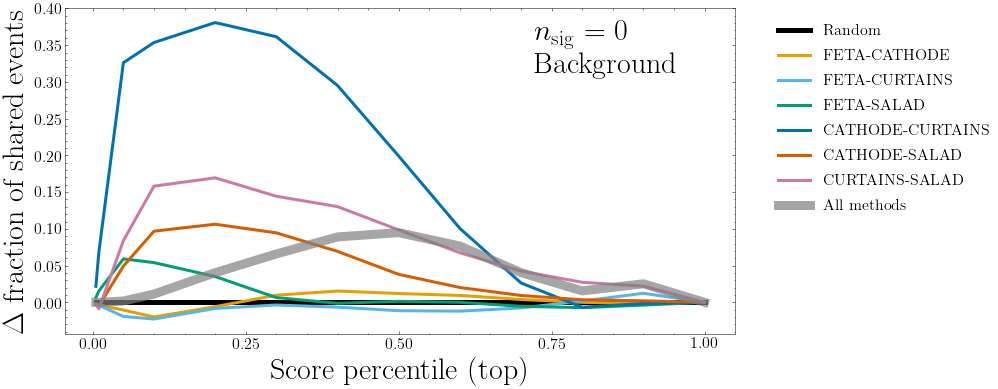

No handles with labels found to put in legend.


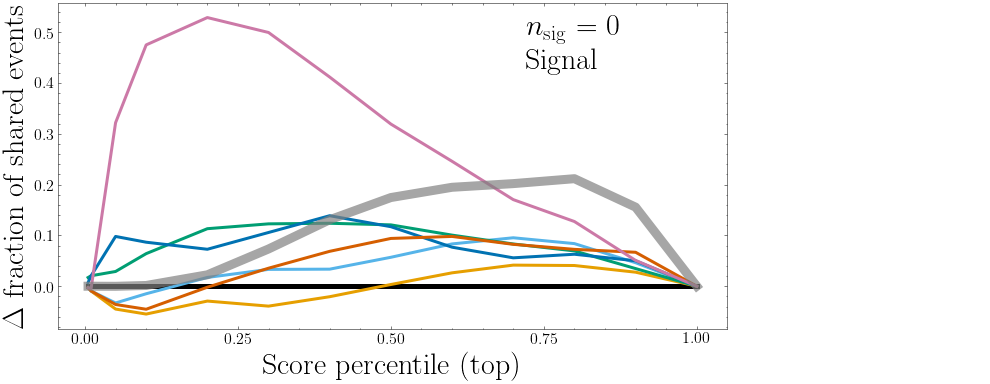

In [9]:
percentiles = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fontsize = 30
small_font = 16

colors = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7"]

plot_residuals = True



l = 3

num_to_plot = 0


"""
BACKGROUND
"""


fig = plt.figure(figsize = (12, 6))
ax = plt.gca()
if plot_residuals: 
    ax.plot(percentiles, random_overlap-random_overlap, label = "Random", linewidth = l+2, color = "black")
else: 
    ax.plot(percentiles, random_overlap, label = "Random", linewidth = l+2, color = "black")
k = 0
for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2 
        plot_label = id_1.upper() + "-" + id_2.upper()
        if plot_residuals: 
            ax.plot(percentiles, pairs_overlap_bkg[pair_id][num_to_plot]-random_overlap, label = f"{plot_label}", linewidth = l, color = colors[k])
        else:
            ax.plot(percentiles, pairs_overlap_bkg[pair_id][num_to_plot], label = f"{plot_label}", linewidth = l, color = colors[k])
        k += 1       
if plot_residuals:
    ax.plot(percentiles, all_overlap_bkg[num_to_plot]-random_overlap_4, label = "All methods", linewidth = l*3, color = "grey", alpha = 0.7)
else:
    ax.plot(percentiles, all_overlap_bkg[num_to_plot], label = "All methods", linewidth = l*3, color = "grey", alpha = 0.7
           )
ax.legend(fontsize = small_font, bbox_to_anchor=(1.4, 1))
ax.set_xlabel("Score percentile (top)", fontsize = fontsize)
ax.set_xticks(ticks=[0, 0.25, 0.5, .75, 1])
ax.tick_params(axis='both', which='major', labelsize=small_font)
ax.text(.7, 0.8, f"$n_\\mathrm{{sig}}$ = {num_to_plot}\nBackground", fontsize = fontsize, transform = ax.transAxes)
if plot_residuals:
    ax.set_ylabel("$\Delta$ fraction of shared events", fontsize = fontsize)
else:
    ax.set_ylabel("Fraction of shared events", fontsize = fontsize)
plt.show()
fig.savefig(f"plots/unification_bkg_{num_to_plot}.pdf", dpi = dpi)


"""
SIGNAL
"""


fig = plt.figure(figsize = (12, 6))
ax = plt.gca()
if plot_residuals: 
    ax.plot(percentiles, random_overlap-random_overlap, label = '_nolegend_', linewidth = l+2, color = "black")
else: 
    ax.plot(percentiles, random_overlap, label = '_nolegend_', linewidth = l+2, color = "black")
k = 0
for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2      
        plot_label = id_1.upper() + "-" + id_2.upper()   
        if plot_residuals: 
            ax.plot(percentiles, pairs_overlap_sig[pair_id][num_to_plot]-random_overlap, label = '_nolegend_', linewidth = l, color = colors[k])
        else:
            ax.plot(percentiles, pairs_overlap_sig[pair_id][num_to_plot], label = '_nolegend_', linewidth = l, color = colors[k])       
        k += 1       
if plot_residuals:
    ax.plot(percentiles, all_overlap_sig[num_to_plot]-random_overlap_4, label = '_nolegend_', linewidth = l*3, color = "grey", alpha = 0.7)
else:
    ax.plot(percentiles, all_overlap_sig[num_to_plot], label = '_nolegend_', linewidth = l*3, color = "grey", alpha = 0.7)
ax.legend(fontsize = small_font, bbox_to_anchor=(1.4, 1))
ax.set_xlabel("Score percentile (top)", fontsize = fontsize)
ax.set_xticks(ticks=[0, 0.25, 0.5, .75, 1])
ax.tick_params(axis='both', which='major', labelsize=small_font)
ax.text(.7, 0.8, f"$n_\\mathrm{{sig}}$ = {num_to_plot}\nSignal", fontsize = fontsize, transform = ax.transAxes)
if plot_residuals:
    ax.set_ylabel("$\Delta$ fraction of shared events", fontsize = fontsize)
else:
    ax.set_ylabel("Fraction of shared events", fontsize = fontsize)


plt.show()

fig.savefig(f"plots/unification_sig_{num_to_plot}.pdf", dpi = dpi)


## For each score pecentile, plot the overlap as a function of the signal injection

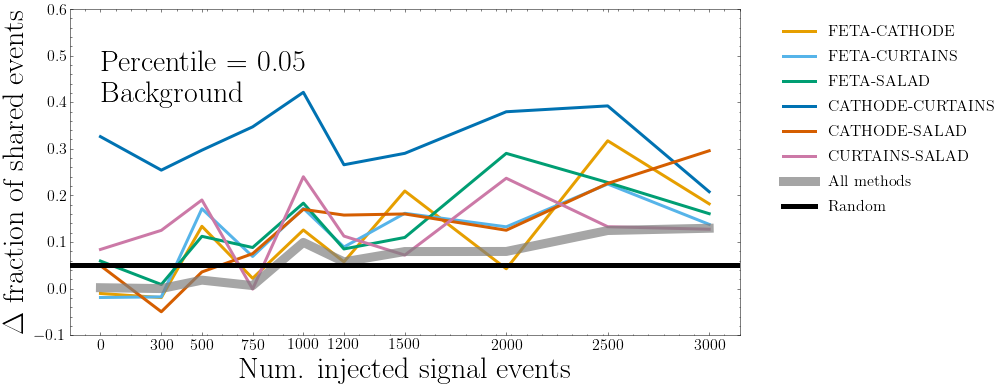

No handles with labels found to put in legend.


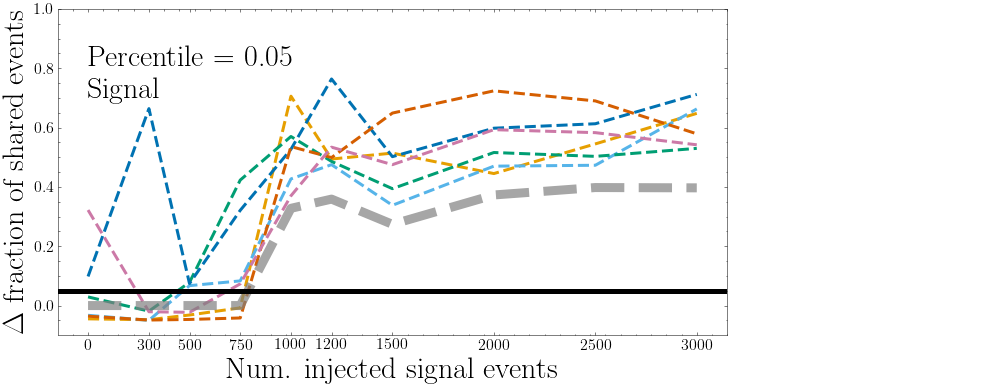

In [11]:
percentiles = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fontsize = 30
small_font = 16

l = 3


target_percentile = 0.05
target_percentile_index = percentiles.index(target_percentile)






loc_overlaps_bkg = {}
loc_overlaps_sig = {}

for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        loc_overlaps_bkg[pair_id] = []
        loc_overlaps_sig[pair_id] = []
        


loc_all_overlap_bkg = []
loc_all_overlap_sig = []
    
    

for nn in num_signals_to_inject:
    
    for i, id_1 in enumerate(synth_ids):
        for j, id_2 in enumerate(synth_ids[i+1:]):
            pair_id = id_1 + "_" + id_2
            
            
            loc_overlaps_bkg[pair_id].append(pairs_overlap_bkg[pair_id][nn][target_percentile_index] - random_overlap[target_percentile_index])
            loc_overlaps_sig[pair_id].append(pairs_overlap_sig[pair_id][nn][target_percentile_index]- random_overlap[target_percentile_index])

    
    loc_all_overlap_bkg.append(all_overlap_bkg[nn][target_percentile_index]- random_overlap_4[target_percentile_index])
    loc_all_overlap_sig.append(all_overlap_sig[nn][target_percentile_index]- random_overlap_4[target_percentile_index])

    
    
    
"""
BACKGROUND
"""
fig = plt.figure(figsize = (12, 6))
ax = plt.gca()

k = 0
for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        plot_label = id_1.upper() + "-" + id_2.upper()
        ax.plot(num_signals_to_inject, loc_overlaps_bkg[pair_id], label = f"{plot_label}", linewidth = l, color = colors[k])      
        k += 1
ax.plot(num_signals_to_inject, loc_all_overlap_bkg, label = "All methods", linewidth = l*3, color = "grey", alpha = 0.7)
ax.axhline(target_percentile, label = "Random", linewidth = l+2, color = "black")
ax.legend(fontsize = small_font, bbox_to_anchor=(1.4, 1))
ax.set_ylim(-.1, 0.6)
ax.set_xlabel("Num. injected signal events", fontsize = fontsize)
ax.set_ylabel("$\Delta$ fraction of shared events", fontsize = fontsize)
ax.set_xticks(ticks=num_signals_to_inject)
ax.tick_params(axis='both', which='major', labelsize=small_font)
ax.text(1.1, 0.4, f"Percentile = {target_percentile}\nBackground", fontsize = fontsize)

plt.show()

fig.savefig(f"plots/unification_percentile_{100*target_percentile}_bkg.pdf", dpi = dpi)


"""
SIGNAL
"""

fig = plt.figure(figsize = (12, 6))
ax = plt.gca()

k = 0
for i, id_1 in enumerate(synth_ids):
    for j, id_2 in enumerate(synth_ids[i+1:]):
        pair_id = id_1 + "_" + id_2
        plot_label = id_1.upper() + "-" + id_2.upper()
        ax.plot(num_signals_to_inject, loc_overlaps_sig[pair_id], label = f"_nolegend_", linewidth = l, color = colors[k], linestyle = "dashed")
        k += 1
ax.plot(num_signals_to_inject, loc_all_overlap_sig,  label = "_nolegend_", linewidth = l*3, color = "grey", alpha = 0.7, linestyle = "dashed")
ax.axhline(target_percentile, label = "_nolegend_", linewidth = l+2, color = "black")

ax.legend(fontsize = small_font, bbox_to_anchor=(1.4, 1))

ax.set_ylim(-.1, 1.)
ax.set_xlabel("Num. injected signal events", fontsize = fontsize)
ax.set_ylabel("$\Delta$ fraction of shared events", fontsize = fontsize)
ax.set_xticks(ticks=num_signals_to_inject)
ax.tick_params(axis='both', which='major', labelsize=small_font)
ax.text(1.1, 0.7, f"Percentile = {target_percentile}\nSignal", fontsize = fontsize)

plt.show()

fig.savefig(f"plots/unification_percentile_{100*target_percentile}_sig.pdf", dpi = dpi)

